#Import Library

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Overview Data

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

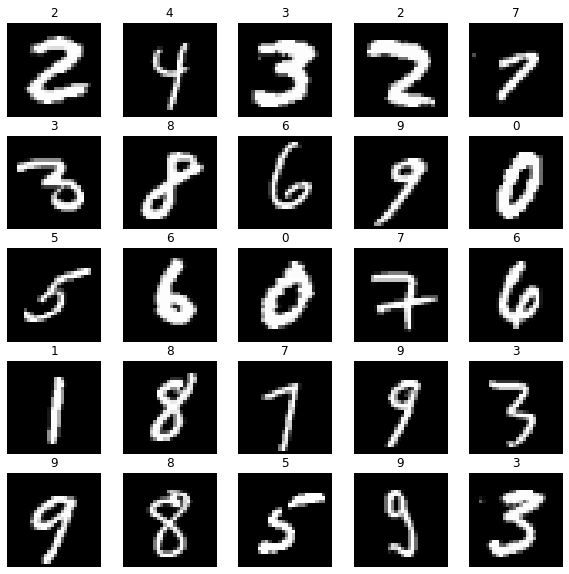

In [ ]:
n = 5
start = 25
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
for i in range(n*n):
  img = x_train[start+i]
  axs[i//n, i%n].imshow(img, cmap='gray')
  axs[i//n, i%n].set_title(y_train[start+i])
  axs[i//n, i%n].axis('off')

plt.show()

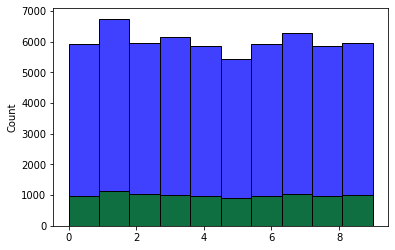

In [ ]:
sns.histplot(y_train, bins=10, color='blue')
sns.histplot(y_test, bins=10, color='green')
plt.show()

#Preprocessing

In [ ]:
df_train = pd.DataFrame(
    data={"label":y_train}
)
df_test = pd.DataFrame(
    data={"label":y_test}
)

In [ ]:
df_test

,label
0,7
1,2
2,1
3,0
4,4
...,...
9995,2
9996,3
9997,4
9998,5


In [ ]:
img_size = 64

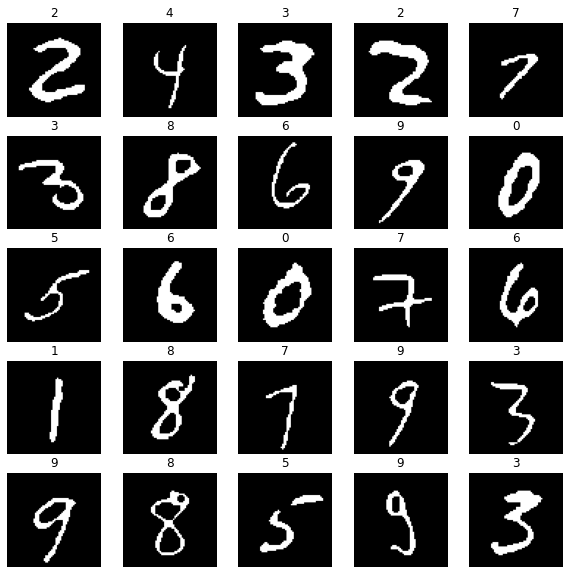

In [ ]:
n = 5
start = 25
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
kernel = np.ones((3, 3), np.uint8)
for i in range(n*n):
  img = x_train[start+i]
  img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img = cv2.erode(img, kernel, iterations=1)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  axs[i//n, i%n].imshow(img, cmap='gray')
  axs[i//n, i%n].set_title(y_train[start+i])
  axs[i//n, i%n].axis('off')

plt.show()

#Tensorflow

In [3]:
import tensorflow.keras.layers as layers

##Tensorflow Dataset

In [4]:
img_size = 64
y_train_categoric = keras.utils.to_categorical(y_train, num_classes=10)
y_test_categoric = keras.utils.to_categorical(y_test, num_classes=10)

In [5]:
y_train_categoric.shape

(60000, 10)

In [6]:
def preprocessing(img):
  kernel = np.ones((3, 3), np.uint8)
  img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img = cv2.erode(img, kernel, iterations=1)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  return img

def map_preprocess(img, label):
  img = tf.numpy_function(preprocessing, [img], tf.uint8)
  img = tf.expand_dims(img, axis=2)
  img = tf.cast(img, tf.float32)/255.0
  return img, label

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_categoric))
train_dataset = train_dataset.map(map_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_categoric))
valid_dataset = valid_dataset.map(map_preprocess, num_parallel_calls=AUTOTUNE)
valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

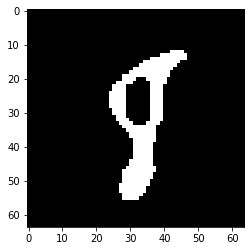

In [ ]:
for images, labels in train_dataset.take(1):
  for image, label in zip(images, labels):
    np_image = image.numpy()
    np_image = np.squeeze(image, axis=2)
    plt.imshow(np_image, cmap='gray')
    break
  plt.show()

##Model

In [ ]:
def PackConv2D(x_in, filters, kernel=3):
  x = layers.Conv2D(filters, kernel_size=kernel, padding='same', activation='relu')(x_in)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D()(x)
  return x

def create_model():
  inputs = layers.Input((img_size, img_size, 1))
  x = layers.Conv2D(8, 3, padding='same', activation='relu')(inputs)
  x = PackConv2D(x, 16)
  x = PackConv2D(x, 32)
  x = layers.Flatten()(x)
  outputs = layers.Dense(10, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
model = create_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                      

In [ ]:
METRICS = [
           'accuracy',
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')
]

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/mnist.h5',
    monitor='val_accuracy',
    save_best_only=True
)

model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(5e-4),
    metrics = METRICS
)

In [ ]:
model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[checkpoint_callback])

Epoch 1/10
469/469 [==============================] - 20s 40ms/step - loss: 0.0833 - accuracy: 0.9761 - precision: 0.9781 - recall: 0.9747 - auc: 0.9982 - val_loss: 0.0681 - val_accuracy: 0.9775 - val_precision: 0.9796 - val_recall: 0.9766 - val_auc: 0.9987
Epoch 2/10
469/469 [==============================] - 18s 37ms/step - loss: 0.0452 - accuracy: 0.9862 - precision: 0.9872 - recall: 0.9853 - auc: 0.9992 - val_loss: 0.0804 - val_accuracy: 0.9766 - val_precision: 0.9782 - val_recall: 0.9760 - val_auc: 0.9979
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.0286 - accuracy: 0.9911 - precision: 0.9917 - recall: 0.9905 - auc: 0.9996 - val_loss: 0.0652 - val_accuracy: 0.9821 - val_precision: 0.9834 - val_recall: 0.9814 - val_auc: 0.9982
Epoch 4/10
469/469 [==============================] - 18s 37ms/step - loss: 0.0175 - accuracy: 0.9938 - precision: 0.9945 - recall: 0.9935 - auc: 0.9998 - val_loss: 0.0824 - val_accuracy: 0.9810 - val_precision: 0.9817 - val_r

## Predict on Test set

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/mnist.h5')
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                      

In [ ]:
def preprocessing_test(img):
  kernel = np.ones((3, 3), np.uint8)
  img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img = cv2.erode(img, kernel, iterations=1)
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  return img

def map_preprocess_test(img):
  img = tf.numpy_function(preprocessing_test, [img], tf.uint8)
  img = tf.expand_dims(img, axis=2)
  img = tf.cast(img, tf.float32)/255.0
  return img

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.map(map_preprocess_test, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
predict_onehot = model.predict(test_dataset)

In [ ]:
predict_onehot

array([[1.1862044e-20, 1.9402028e-22, 6.8417900e-16, ..., 1.0000000e+00,
        4.9100126e-18, 7.1946326e-15],
       [1.7077124e-18, 3.4683408e-13, 1.0000000e+00, ..., 1.0292239e-22,
        2.1156394e-19, 2.6744149e-22],
       [1.2728935e-08, 9.9993324e-01, 1.7608593e-07, ..., 3.6914068e-07,
        6.2788098e-07, 3.6321823e-10],
       ...,
       [8.9083072e-24, 1.5810343e-17, 2.9573646e-20, ..., 5.7493676e-12,
        1.3686101e-10, 9.5202575e-11],
       [2.7511999e-19, 9.4469860e-25, 1.7912970e-21, ..., 1.1387688e-15,
        6.4752254e-10, 1.0028537e-15],
       [1.6487674e-20, 1.3917353e-22, 3.6694783e-10, ..., 3.6246460e-25,
        1.1654321e-14, 8.4866653e-23]], dtype=float32)

In [ ]:
predict = np.argmax(predict_onehot, axis=1)

In [ ]:
predict

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Text(69.0, 0.5, 'Truth')

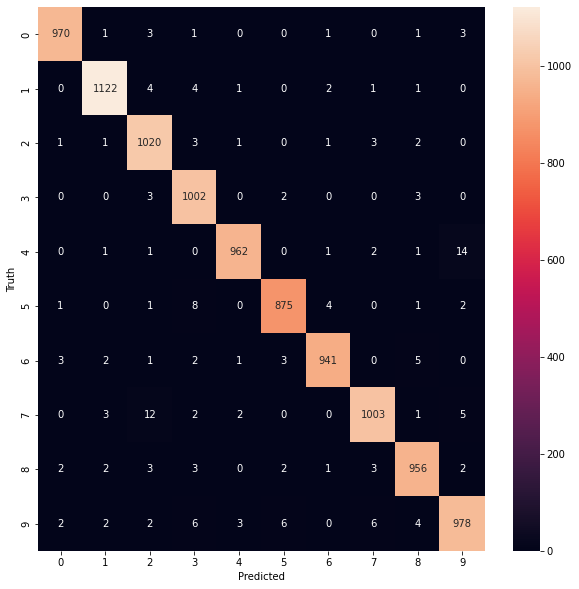

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(
    y_test, 
    predict
))

cm = confusion_matrix(y_test, predict)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')